In [1]:
%matplotlib inline

import numpy as np
import pylab as plt
import ngene as ng
from ngene.architectures.simple import architecture
import ccgpack as ccg
import tensorflow as tf
from tqdm import tqdm, trange
from scipy.stats import ttest_ind

/home/gf/packages/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
cl = np.load('../data/cl_planck_lensed.npy')
sfs = ccg.StochasticFieldSimulator(cl)
size = 7.2

In [3]:
# alpha = 1

# fig, (ax1,ax2)= plt.subplots(ncols=2, nrows=1, figsize=(20, 10))

# num = 400
# imgx = np.zeros((num, num), dtype=np.double)
# imgy = np.zeros((num, num), dtype=np.double)

# begins = ccg.random_inside(imgx,num=50)
# ends = ccg.random_inside(imgx,num=50)

# g = sfs.simulate(num,size)
# g -= g.min()
# g /= g.max()    
# s = ccg.draw_line(imgx,begins=begins,ends=ends,value=1)

# imgx = g+alpha*s
# imgy = s

# ax1.imshow(imgx)
# ax1.axis('off')
# ax2.imshow(imgy)
# ax2.axis('off')

In [4]:
class DataProvider(object):
    
    def __init__(self,nside,size,alpha,num,n_buffer=200,reinit=1000):
        
        self.nside = nside
        self.alpha = alpha
        self.num = num
        self.size = size
        self.n_buffer = n_buffer
        self.reinit = reinit
        self.couter = 0
        
    def simulate(self):
        
        s = np.zeros((self.nside, self.nside), dtype=np.double)
        begins = ccg.random_inside(s,num=self.num)
        ends = ccg.random_inside(s,num=self.num)

        g = sfs.simulate(self.nside,self.size)
        g -= g.min()
        g /= g.max()    
        s = ccg.draw_line(s,begins=begins,ends=ends,value=1)

        return g,s
    
    def simulation_initiation(self):
        gs = []
        ss = []    
#         for i in tqdm(range(self.n_buffer), total=self.n_buffer, unit=" map", desc='Initiation', ncols=70):
        for i in range(self.n_buffer):
            g,s = self.simulate()
            gs.append(g)
            ss.append(s)
        return np.array(gs),np.array(ss)
        
    def __call__(self,n):
        
        if self.couter%self.reinit==0:
            self.gs, self.ss = self.simulation_initiation()
        self.couter += 1
        x_out = []
        y_out = []
        for i in range(n):
            i_g,i_s = np.random.randint(0,self.n_buffer,2)
            x_out.append(self.gs[i_g]+self.alpha*self.ss[i_s])
            y_out.append(self.ss[i_s])
            
        x_out = np.array(x_out)
        y_out = np.array(y_out)
        return np.expand_dims(x_out,-1),np.expand_dims(y_out,-1)
        

In [5]:
nside=200
dp = DataProvider(nside=nside,size=7,alpha=0.7,num=50)
dp0 = DataProvider(nside=nside,size=7,alpha=0,num=50,n_buffer=100)
x,y = dp0(1)
x,y = dp(1)

(-0.5, 199.5, 199.5, -0.5)

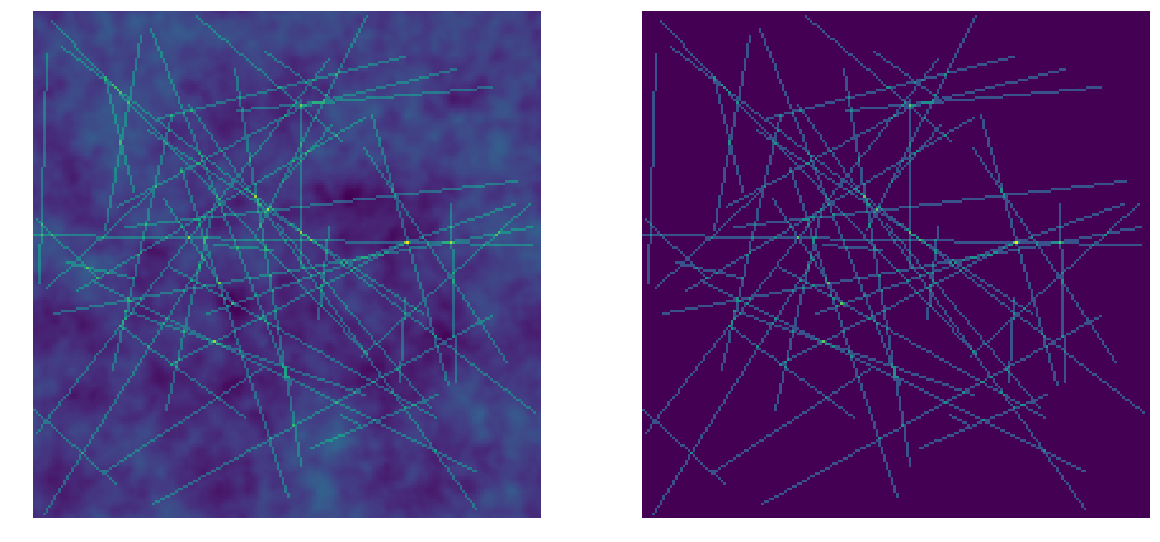

In [6]:
fig, (ax1,ax2)= plt.subplots(ncols=2, nrows=1, figsize=(20, 10))

ax1.imshow(x[0,:,:,0])
ax1.axis('off')
ax2.imshow(y[0,:,:,0])
ax2.axis('off')

In [7]:
def arch(x_in):
    x_out = architecture(x_in=x_in,n_layers=5,res=2)
    return x_out

def check():
    l0 = []
    l1 = []
    for i in range(100):
        x,y = dp(1)
        x0,y = dp0(1)
        l0.append(model.conv(x0).std())
        l1.append(model.conv(x).std())
    b0,h0 = ccg.pdf(l0,20)
    b1,h1 = ccg.pdf(l1,20)
    plt.plot(b0,h0)
    plt.plot(b1,h1)
    print('p-value:',ttest_ind(l0,l1)[1])
    return ttest_ind(l0,l1)[1]

In [8]:
model = ng.Model(nx=nside,ny=nside,n_channel=1,n_class=1,
         restore=0,model_add='./model/'+str(0)+'_'+str(dp.alpha),arch=arch)

print('# of variables:',model.n_variables)

Tensor("layer_1_act:0", shape=(?, 200, 200, 12), dtype=float32)
Tensor("layer_2_act:0", shape=(?, 200, 200, 12), dtype=float32)
Tensor("layer_3_act:0", shape=(?, 200, 200, 12), dtype=float32)
Tensor("layer_4_act:0", shape=(?, 200, 200, 12), dtype=float32)
Res layer 4 + 2 :
Tensor("add:0", shape=(?, 200, 200, 12), dtype=float32)
Tensor("layer_5_norm/FusedBatchNorm:0", shape=(?, 200, 200, 1), dtype=float32)
# of variables: 11547


Epoch:0, cost= 50059.480859
Epoch:1, cost= 49209.325586
Epoch:2, cost= 49328.855078
Epoch:3, cost= 49181.590039
Epoch:4, cost= 48546.597266
Epoch:5, cost= 49069.669531
Epoch:6, cost= 49179.655273
Epoch:7, cost= 48622.326172
Epoch:8, cost= 48797.763672
Epoch:9, cost= 49447.732617
p-value: 0.9589555797848718


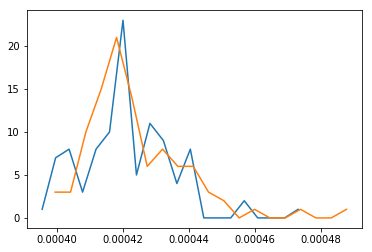

In [50]:
model.train(data_provider=dp,training_epochs = 10,iterations=20 ,n_s = 10,
                    learning_rate = 0.01, time_limit=None,
                    metric=None, verbose=1,death_preliminary_check = 30,
                    death_frequency_check = 1000)
pv = check()

Text(0.5,1,'Prediction')

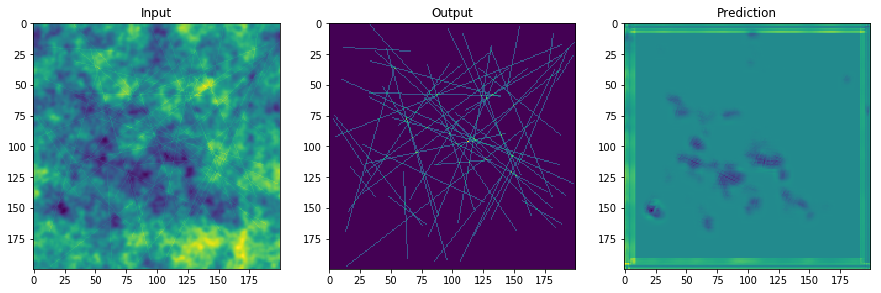

In [51]:
fig,(ax1,ax2,ax3) = plt.subplots(ncols=3,nrows=1,figsize=(15,7))

x,y = dp(1)
x_pred = model.conv(x)

ax1.imshow(x[0,:,:,0])
ax1.set_title('Input')
ax2.imshow(y[0,:,:,0])
ax2.set_title('Output')
ax3.imshow(x_pred[:,:,0])
ax3.set_title('Prediction')

In [52]:
dp.alpha

0.0518749999999999

In [38]:
alphas

[0.009374999999999908, 0.004374999999999908, -0.0006250000000000925]

Epoch:0, cost= 47850.981250
Epoch:1, cost= 47451.963672
Epoch:2, cost= 48573.077734
Epoch:3, cost= 48236.819531
Epoch:4, cost= 47112.295312
p-value: 0.5978785270171152
0.5978785270171152
0.0468749999999999
Epoch:0, cost= 47535.765625
Epoch:1, cost= 361749.996484
Epoch:2, cost= 49105.009766
Epoch:3, cost= 48126.283594
Epoch:4, cost= 48032.672266
p-value: 0.9472421486399416
0.9472421486399416
0.0518749999999999
Epoch:0, cost= 47530.024609
Epoch:1, cost= 48471.473828
Epoch:2, cost= 47126.287109
Epoch:3, cost= 47225.397266
Epoch:4, cost= 46167.572266
p-value: 1.5545982350252792e-55
1.5545982350252792e-55
0.0493749999999999
Epoch:0, cost= 47585.596484
Epoch:1, cost= 46939.008203
Epoch:2, cost= 49219.617188
Epoch:3, cost= 47553.648828
Epoch:4, cost= 47157.132812
p-value: 0.6629048707506324
0.6629048707506324
0.0506249999999999
Epoch:0, cost= 48555.291016
Epoch:1, cost= 48914.818359
Epoch:2, cost= 48738.206641
Epoch:3, cost= 48736.185156
Epoch:4, cost= 48982.704297
p-value: 0.2199898018571687

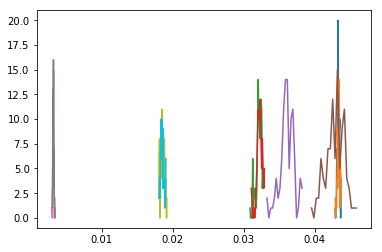

In [43]:
alphas = []

dalpha = 0.005
p_move = 0

for i in range(5):

    model.train(data_provider=dp,training_epochs = 5,iterations=10 ,n_s = 10,
                        learning_rate = 0.01, time_limit=None,
                        metric=None, verbose=1,death_preliminary_check = 30,
                        death_frequency_check = 1000)
    pv = check()
    print(pv)
    if pv<1e-7:
        if p_move == 1:
            dalpha = dalpha/2
            while dalpha>dp.alpha:
                dalpha = dalpha/2
        dp.alpha = dp.alpha-dalpha
        p_move = -1
    else:
        if p_move == -1:
            dalpha = dalpha/2
            while dalpha>dp.alpha:
                dalpha = dalpha/2
        dp.alpha = dp.alpha+dalpha
        p_move = 1
        
    alphas.append(dp.alpha)
    print(dp.alpha)
        
    model.model_add='./model/'+str(i+1)+'_'+str(dp.alpha)

In [ ]:
plt.imshow(np.squeeze(y)-np.squeeze(x_pred))

In [ ]:


b0,h0 = pdf(l0,20)
b1,h1 = pdf(l1,20)
plt.plot(b0,h0)
plt.plot(b1,h1)
print('p-value:',ttest_ind(l0,l1)[1])